In [27]:
%load_ext autoreload
%autoreload 2

from utilities.plotting import get_files, get_avg, read_series_csv, format_df, reformat_x_labels, confusion_plot
from embeddings.tokenization import load_labels

from utilities.baselines import hist_gradient_boosting_classifier, embed_data, load_labels, model_context, random_forest_classification, gradient_boosting_classifier

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### AMR - gentamicin resistance

### Inspecting metadata

Data is located in on healthtech cluster: /home/projects2/ecoli_gentamicin/all_genomes/

Metadata is located on healthtech cluster:  /home/projects2/ecoli_gentamicin/metadata_ecoli_gentamicin.csv 

id column: genome_id,
label column: resistant_phenotype

In [19]:
genome_summary_path = "../data/AMR_gentamicin/metadata_ecoli_gentamicin.csv"
genome_lineage = pd.read_csv(genome_summary_path)

genome_lineage

,genome_id,genome_name_x,taxon_id_x,genome_status,strain,serovar,pathovar,mlst,other_typing,culture_collection,...,resistant_phenotype,measurement,measurement_sign,measurement_value,measurement_unit,laboratory_typing_method,laboratory_typing_platform,vendor,testing_standard,testing_standard_year
0,562.140902,Escherichia coli 001-E1-DxU,562,WGS,001-E1-DxU,NaN,NaN,"MLST.Escherichia_coli_2.44,MLST.Escherichia_co...",NaN,NaN,...,Resistant,NaN,NaN,NaN,NaN,Disk diffusion,NaN,Hardy Diagnostics,CLSI,2015.0
1,562.140907,Escherichia coli 001-E1-S04,562,WGS,001-E1-S04,NaN,NaN,MLST.Escherichia_coli_1.405,NaN,NaN,...,Resistant,NaN,NaN,NaN,NaN,Disk diffusion,NaN,Hardy Diagnostics,CLSI,2015.0
2,562.140901,Escherichia coli 001-E1-S06,562,WGS,001-E1-S06,NaN,NaN,"MLST.Escherichia_coli_2.44,MLST.Escherichia_co...",NaN,NaN,...,Resistant,NaN,NaN,NaN,NaN,Disk diffusion,NaN,Hardy Diagnostics,CLSI,2015.0
3,562.140894,Escherichia coli 006-E1-DxU,562,WGS,006-E1-DxU,NaN,NaN,MLST.Escherichia_coli_1.131,NaN,NaN,...,Resistant,NaN,NaN,NaN,NaN,Disk diffusion,NaN,Hardy Diagnostics,CLSI,2015.0
4,562.140893,Escherichia coli 006-E1-S01,562,WGS,006-E1-S01,NaN,NaN,MLST.Escherichia_coli_1.131,NaN,NaN,...,Resistant,NaN,NaN,NaN,NaN,Disk diffusion,NaN,Hardy Diagnostics,CLSI,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,562.586480,Escherichia coli strain WU35,562,WGS,WU35,NaN,NaN,MLST.Escherichia_coli_2.18,NaN,NaN,...,Susceptible,NaN,NaN,NaN,NaN,Disk diffusion,NaN,NaN,CLSI,2015.0
962,562.586470,Escherichia coli strain WU40,562,WGS,WU40,NaN,NaN,"MLST.Escherichia_coli_1.73,MLST.Escherichia_co...",NaN,NaN,...,Susceptible,NaN,NaN,NaN,NaN,Disk diffusion,NaN,NaN,CLSI,2015.0
963,562.586460,Escherichia coli strain WU43,562,WGS,WU43,NaN,NaN,MLST.Escherichia_coli_1.95,NaN,NaN,...,Susceptible,NaN,NaN,NaN,NaN,Disk diffusion,NaN,NaN,CLSI,2015.0
964,562.586450,Escherichia coli strain WU44,562,WGS,WU44,NaN,NaN,MLST.Escherichia_coli_1.131,NaN,NaN,...,Susceptible,NaN,NaN,NaN,NaN,Disk diffusion,NaN,NaN,CLSI,2015.0


In [21]:
genome_lineage[["genome_id","resistant_phenotype"]]

,genome_id,resistant_phenotype
0,562.140902,Resistant
1,562.140907,Resistant
2,562.140901,Resistant
3,562.140894,Resistant
4,562.140893,Resistant
...,...,...
961,562.586480,Susceptible
962,562.586470,Susceptible
963,562.586460,Susceptible
964,562.586450,Susceptible


In [20]:

# Count nr of resistant and susceptible samples
genome_lineage["resistant_phenotype"].value_counts()

resistant_phenotype
Susceptible    543
Resistant      423
Name: count, dtype: int64

### Analysis and Results 

In [30]:
#### Baselines ####

path_baselines = "../results/AMR_gentamicin/baselines"
df_baselines = pd.concat((read_series_csv(path) for path in get_files(path_baselines)))
df_baselines = format_df(df_baselines, metric_cols = [
                "f1_score_weighted","f1_score_macro","precision_weighted","precision_macro",
                "recall_weighted","recall_macro","accuracy","balanced_accuracy"
                ])


#### CNN ####

path_CNN = "../results/AMR_gentamicin/CNN"
df_CNN = pd.concat((read_series_csv(path) for path in get_files(path_CNN)))
df_CNN = format_df(df_CNN)


#### RNN ####

path_RNN = "../results/AMR_gentamicin/RNN"
df_RNN = pd.concat((read_series_csv(path) for path in get_files(path_RNN)))
df_RNN = format_df(df_RNN)

len(dir_list)=20
len(dir_list)=17
len(dir_list)=17


['RandomForest, ACATG, 6' 'HistGradientBoosting, ATG, 8'
 'HistGradientBoosting, ACATG, 6' 'RandomForest, ATG, 8'
 'CNN_ONEHOT_SMALL, onehot, ACATG, 12'
 'CNN_ONEHOT_LARGE, onehot, ACATG, 6'
 'CNN_ONEHOT_LARGE, onehot, ACATG, 12'
 'CNN_ONEHOT_SMALL, onehot, ACATG, 6']


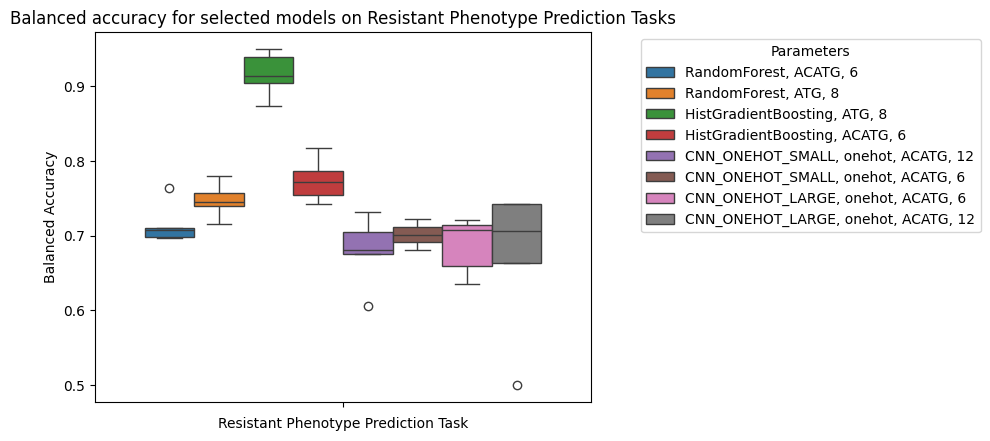

In [ ]:
df = pd.concat([df_baselines, df_CNN])
df['phenotype'] = reformat_x_labels(df['phenotype'])
print(df["Parameters"].unique())

model_order = ["RandomForest", "HistGradientBoosting", "CNN_ONEHOT_SMALL", "CNN_ONEHOT_LARGE"]
suffix_order = ["6","8","12"]
prefix_order = ["ACATG", "ATG"]

ax = sns.boxplot(data = df.set_index(["model_name", "kmer_prefix"]).loc[model_order, ], y = "balanced_accuracy", hue = "Parameters")
#plot.set_xticklabels(plot.get_xticklabels(), rotation=60)
ax.set_title('Balanced accuracy for selected models on Resistant Phenotype Prediction Tasks')
ax.set_ylabel('Balanced Accuracy')
ax.set_xlabel('Resistant Phenotype Prediction Task')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.8, 1))

### Feature importance

In [4]:
labels_path = "../data/AMR_gentamicin/metadata_ecoli_gentamicin.csv"
input_data_directory = "../data/AMR_gentamicin/"
id_column = "genome_id"
dna_sequence_column = "dna_sequence"
phenotype = "resistant_phenotype"
label_return = load_labels(file_path=labels_path, id = id_column, label = phenotype, sep = ",")
label_dict_literal, label_dict, int2label = label_return["label_dict"], label_return["label_dict_int"], label_return["int2label"] 


id='genome_id', label='resistant_phenotype'


In [5]:
import os

In [9]:
dir_list = os.listdir(input_data_directory)
dir_list = [f'{input_data_directory}/{file}' for file in dir_list if "fasta" in file]

kmer_prefix = "ACATG"
kmer_suffix_size = 5
output_data_directory = "../data/AMR_gentamicin"
embedding_class = "frequency"

X, y = embed_data(label_dict=label_dict, 
					input_data_directory=input_data_directory,
                    output_data_directory = output_data_directory, 
					kmer_prefix=kmer_prefix, 
					kmer_suffix_size = kmer_suffix_size, 
                    kmer_offset=0,
					id_column = id_column,
					sequence_column = dna_sequence_column,
					embedding_class=embedding_class,
					cores = 2,
					reembed=True,
					file_type="fasta",
                    reverse_complement=False,
					
					)
ctx = model_context(
							X,
							y, 
							output_data_directory, 
							phenotype, 
							kmer_prefix, 
							kmer_suffix_size,
							model_type=None,
							int2label=int2label,
							k_folds=5,
                            embedding_class=embedding_class)
		

Found 200 files with type fasta in ../data/AMR_gentamicin
Starting tokenization with 2 cores...
Finished tokenization. Total genomes tokenized: 200
Running counts embedder
gid_and_strand_id[:10]=[['562.23305', 'forward'], ['562.140839', 'forward'], ['562.22535', 'forward'], ['562.22508', 'forward'], ['562.22609', 'forward'], ['562.140841', 'forward'], ['562.22887', 'forward'], ['562.22594', 'forward'], ['562.22569', 'forward'], ['562.22489', 'forward']]
len(X)=200
len(ids)=200
len(groups)=200
Saving embeddings to: ../data/AMR_gentamicin/counts_prefix_ACATG_suffixsize_5.npz
len(X)=200
len(y)=200


In [10]:
clf = gradient_boosting_classifier(ctx)


Accuracy of GradientBoosting: 0.7
Saved tmp result to path='../data/AMR_gentamicin/tmp_result_frequency_GradientBoosting_resistant_phenotype_ACATG_5_0.csv'
results=phenotype                            resistant_phenotype
model_name                              GradientBoosting
seed                                                   0
kmer_prefix                                        ACATG
kmer_suffix_size                                       5
f1_score_weighted                               0.698485
f1_score_macro                                   0.69697
precision_weighted                              0.700512
precision_macro                                 0.700767
recall_weighted                                      0.7
recall_macro                                    0.696742
accuracy                                             0.7
balanced_accuracy                               0.696742
n_classes                                              2
confusion_matrix                      

In [11]:
def bin_to_dna_str(number, kmer_size):
	# Converting bits to individual numbers
	twobits = [(number >> bit) & 0b11 for bit in range(0, kmer_size*2, 2)]
	
	kmer = ""
	
	#and every 2nd bit together with 0b11
	
	for twobit in twobits:
		
		if twobit == 0b00:
			kmer += "A"
		elif twobit == 0b11:
			kmer += "T"
		elif twobit == 0b01:
			kmer += "C"
		else:
			kmer += "G"
	
	return kmer

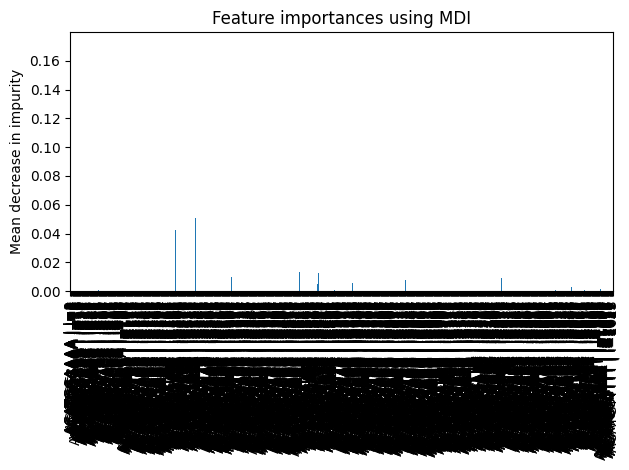

In [12]:
importances = clf[0].feature_importances_
feature_names = [f'{kmer_prefix}{bin_to_dna_str(i, 5)} | {i=}' for i in range(len(X[0]))]
#std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [14]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ctx.X, ctx.y, random_state = 0, test_size= 0.2)
		

result = permutation_importance(
    clf[0], X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [18]:
forest_importances[forest_importances > 0]
forest_importances.nlargest(10)


ACATGAGGGG | i=680    0.0900
ACATGGCATA | i=198    0.0375
ACATGGTAGG | i=654    0.0375
ACATGGAGCC | i=354    0.0325
ACATGAATGC | i=432    0.0175
ACATGGGCGC | i=410    0.0125
ACATGCTAAC | i=269    0.0050
ACATGACCTA | i=212    0.0025
ACATGGCGAC | i=294    0.0025
ACATGCAGCT | i=865    0.0025
dtype: float64

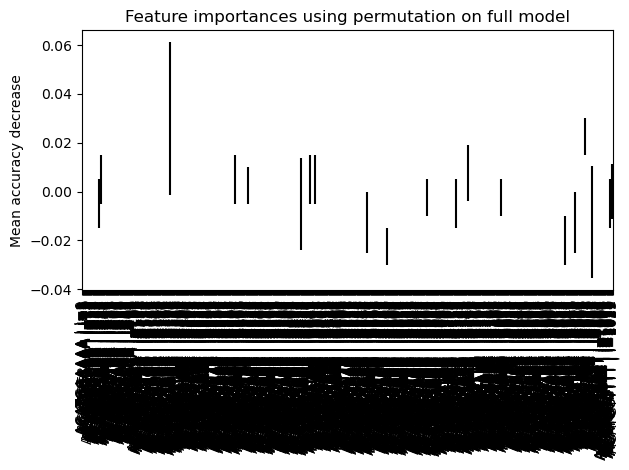

In [150]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()